In [237]:
import pandas as pd
from impyute.imputation.cs import mice#
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer#
import missingno as msno#
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform, pdist
from missingpy import KNNImputer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set()
pd.set_option("display.max_rows", 8)
plt.rcParams['figure.figsize'] = (9, 6)
from missingpy import MissForest
import io
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import accuracy_score

In [2]:
Dapp = pd.read_csv("horse-colic.data" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
Dtest = pd.read_csv("horse-colic.test" , sep = "\s+", names = ["V"+str(i) for i in range(28)])
liste_drop = ["V22","V23","V24","V25","V26","V27"]
Dapp = Dapp.drop(liste_drop , axis = 1)
Dtest = Dtest.drop(liste_drop , axis = 1)
Dapp = Dapp.replace("?",np.nan)
Dtest = Dtest.replace("?",np.nan)

#Dtest
#Dapp
#On utilisera une méthode d'imputation qui gère différentes types pour les variables ! (cf Référence)
#On se doit tout de même spécifier le type des variables


In [3]:
d = {}
liste_categorical = [] ; liste_numerical = []
for i in range(22):
    if(i in list(range(3)) + list(range(6 , 15)) + [16 , 17 , 20]):
        d["V"+str(i)] = "category"
        liste_categorical.append("V"+str(i))
    else:
        d["V"+str(i)] = "float64"
        liste_numerical.append("V"+str(i))
liste_categorical
liste_numerical

['V3', 'V4', 'V5', 'V15', 'V18', 'V19', 'V21']

In [222]:
Dapp = Dapp.astype(d)
Dtest = Dtest.astype(d)
Dapp_num = Dapp.select_dtypes(include=['float64']) ; Dapp_cat = Dapp.select_dtypes(include=['category'])
Dtest_num = Dtest.select_dtypes(include=['float64']) ; Dtest_cat = Dtest.select_dtypes(include=['category'])
Dtest_cat.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat.loc[: , "V9"], categories=["1","2","3"]))

In [223]:
def g(l):
    return np.array([float(x) for x in l])

imputed_training=mice(np.array(list(map(g , Dapp_num.values))))
imputed_test = mice(np.array(list(map(g , Dtest_num.values))))

Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_training))))).round(2)
Dapp_num_imputed.columns = liste_numerical

Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputed_test))))).round(2)
Dtest_num_imputed.columns = liste_numerical

In [224]:
## On a généré quelques valeurs négatives, il est nécessaire d'effectuer de nouvelles imputations sur nos données
Dapp_num_imputed[Dapp_num_imputed < 0] = np.nan
Dtest_num_imputed[Dtest_num_imputed < 0] = np.nan

distances_app = pdist(Dapp_num_imputed.values, metric='euclidean')
dist_matrix_app = squareform(distances_app)
matrice_distance_app = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_app))))).round(2)

distances_test = pdist(Dtest_num_imputed.values, metric='euclidean')
dist_matrix_test = squareform(distances_test)
matrice_distance_test = pd.DataFrame(list(map(np.ravel, (list(dist_matrix_test))))).round(2)


In [225]:
#on ne peut pas se permettre de prendre des poids uniformes
#en effet, il se peut que le 2e plus proche soit en réalité très loin du point par rapport au premier

imputer = KNNImputer(n_neighbors=15, weights="distance")
Dapp_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dapp_num_imputed)))))).round(2)

imputer = KNNImputer(n_neighbors=3, weights="distance")
Dtest_num_imputed = pd.DataFrame(list(map(np.ravel, (list(imputer.fit_transform(Dtest_num_imputed)))))).round(2)

Dapp_num_imputed.columns = liste_numerical ; Dtest_num_imputed.columns = liste_numerical
#le choix du nombre de voisins est difficile, on fait donc des choix arbitraires


C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Benco\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)


In [8]:
{lab : 1-(len(Dtest_num[lab].dropna())/len(Dtest_num)) for lab in liste_numerical} 
{lab : 1-(len(Dapp_num[lab].dropna())/len(Dapp_num)) for lab in liste_numerical} 


{'V3': 0.19999999999999996,
 'V4': 0.07999999999999996,
 'V5': 0.19333333333333336,
 'V15': 0.8233333333333334,
 'V18': 0.09666666666666668,
 'V19': 0.10999999999999999,
 'V21': 0.6599999999999999}

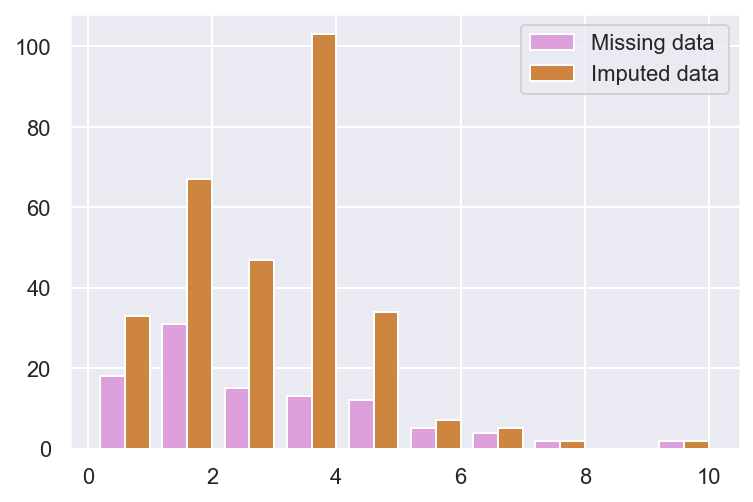

In [54]:
x = Dapp_num.V21
y = Dapp_num_imputed.V21
#L'objectif est de comparer les distributions pour voir si l'on observe une certaine cohérence après imputation
#on compare les distributions avant/après
#on calcule aussi la proportion de données manquantes pour être sûr que la comparaison ait un sens.
#il faut que le % de données manquantes ne soit ni trop faible ni trop élevé pour pouvoir comparer
#on peut faire une "évaluation" visuelle de notre imputation sur cette variable choisie
plt.hist([x, y], label=['Missing data', 'Imputed data'] , color = ["plum","peru"])
plt.legend(loc='upper right')
plt.show()

In [ ]:
##La variable ID hôpital sera supprimée, qui peut être considéré (globalement) comme un identifiant pour les chevaux
##en effet, si l'on conserve cette variable en termes d'ajustement, on sera performant.
##cependant, nos algorithmes de prédiction ne seront pas bons d'un point de vue de la généralisation
#62 lignes des données de test sont des nouveaux identifiants -- > overfitting

#Réf : Unleash Machine Learning Techniques, De Raghav Bali, Dipanjan Sarkar, Brett Lantz p.393
#Advances in Computing and Information Technolog, Natarajan Meghanathan, Dhinaharan Nagamalai, Nabendu Chaki P.352

In [227]:
Dapp_cat = Dapp_cat.drop(["V2"] , axis = 1) ; Dtest_cat = Dtest_cat.drop(["V2"] , axis = 1)
cat_cols = [Dapp_cat.columns.get_loc(col) for col in Dapp_cat.select_dtypes(['category']).columns.tolist()]

imputer = MissForest(random_state = 100)
Dapp_cat_imputed = imputer.fit_transform(Dapp_cat , cat_vars = cat_cols)
Dapp_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dapp_cat_imputed)))))
Dapp_cat_imputed.columns = [x for x in liste_categorical if(x!="V2")] #if(x!="V2")
Dapp_cat_imputed = Dapp_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)

imputer = MissForest(random_state = 100)
Dtest_cat_imputed = imputer.fit_transform(Dtest_cat , cat_vars = cat_cols)
Dtest_cat_imputed = pd.DataFrame(list(map(np.ravel, (list(Dtest_cat_imputed)))))
Dtest_cat_imputed.columns = [x for x in liste_categorical if(x!="V2")] #if(x!="V2")
Dtest_cat_imputed = Dtest_cat_imputed.apply(lambda x : x.astype(int).astype(str).astype("category") , axis = 1)
Dtest_cat_imputed.loc[: , "V9"] = pd.Series(pd.Categorical(Dtest_cat_imputed.loc[: , "V9"], categories=["1","2","3"]))
#une modalité de V9 n'est pas présente dans la variable V9 des données de test : il faut rajouter une catégorie
#pour la variable V9 des données de test

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [175]:
Dapp_cat_imputed.shape

(300, 14)

In [11]:
{lab : 1-(len(Dtest_cat[lab].dropna())/len(Dtest)) for lab in liste_categorical if(lab != "V2")} 
{lab : 1-(len(Dapp_cat[lab].dropna())/len(Dapp)) for lab in liste_categorical if(lab != "V2")}
#les proportions de données manquantes pour chaque varible

{'V0': 0.0033333333333332993,
 'V1': 0.0,
 'V6': 0.18666666666666665,
 'V7': 0.22999999999999998,
 'V8': 0.15666666666666662,
 'V9': 0.10666666666666669,
 'V10': 0.18333333333333335,
 'V11': 0.1466666666666666,
 'V12': 0.18666666666666665,
 'V13': 0.3466666666666667,
 'V14': 0.3533333333333334,
 'V16': 0.33999999999999997,
 'V17': 0.3933333333333333,
 'V20': 0.55}

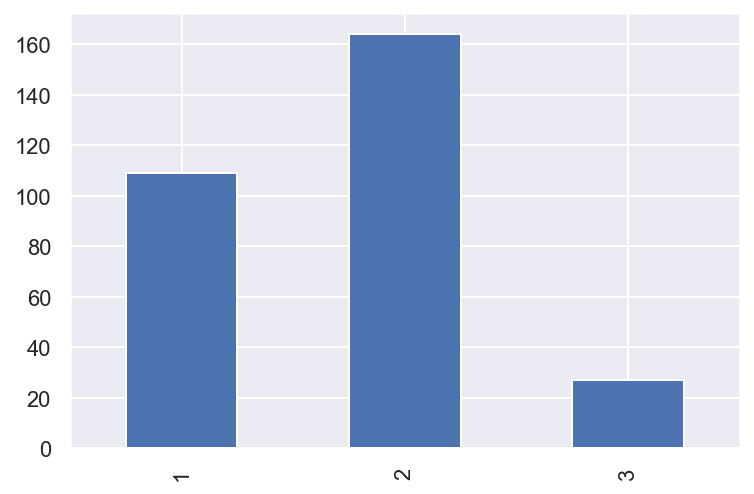

In [37]:
Dapp_cat_imputed.V13.value_counts().sort_index().plot(kind = "bar")
#en pratique, il est nécessaire de vérifier la distribution des variables avant\après imputation
#on trace donc des barplot pour avoir une idée

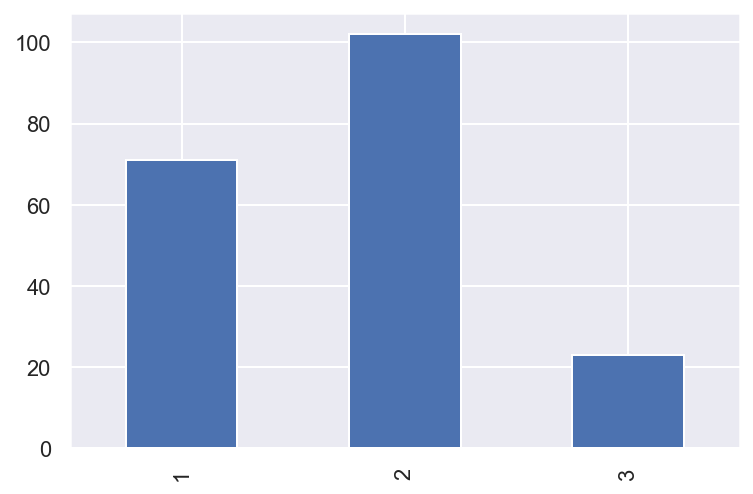

In [13]:
Dapp_cat["V13"].value_counts().sort_index().plot(kind = "bar")

In [228]:
Dapp_imputed = pd.concat([Dapp_num_imputed.reset_index(drop=True), Dapp_cat_imputed], axis=1)
Dapp_imputed.columns = [int(x[1:]) for x in Dapp_imputed.columns]
Dapp_imputed = Dapp_imputed.sort_index(axis = 1)
Dapp_imputed.columns = ["V"+str(x) for x in Dapp_imputed.columns]

Dtest_imputed = pd.concat([Dtest_num_imputed.reset_index(drop=True), Dtest_cat_imputed], axis=1)
Dtest_imputed.columns = [int(x[1:]) for x in Dtest_imputed.columns]
Dtest_imputed = Dtest_imputed.sort_index(axis = 1)
Dtest_imputed.columns = ["V"+str(x) for x in Dtest_imputed.columns]
Dtest_imputed

,V0,V1,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,2,1,38.5,54.0,20.0,3,1,2,2,3,...,1,2,2,5.90,4,2,42.0,6.3,3,1.99
1,2,1,37.6,48.0,36.0,1,1,1,1,3,...,2,2,1,4.25,3,5,44.0,6.3,1,5.00
2,1,1,37.7,44.0,28.0,3,4,3,2,5,...,4,1,1,4.08,3,5,45.0,70.0,3,2.00
3,1,1,37.0,56.0,24.0,3,1,4,2,4,...,3,1,1,4.77,4,5,35.0,61.0,3,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2,1,37.8,42.0,40.0,1,1,1,1,1,...,1,2,1,5.08,3,3,36.0,6.2,1,2.27
65,1,1,38.0,60.0,12.0,1,1,2,1,2,...,1,1,1,4.91,1,4,44.0,65.0,3,2.00
66,2,1,38.0,42.0,12.0,3,1,3,1,1,...,1,2,1,5.36,4,1,37.0,5.8,2,2.86
67,2,1,37.6,88.0,36.0,3,1,1,1,3,...,2,1,3,1.50,4,4,44.0,6.0,2,13.02


In [178]:
Dapp_imputed.shape

(300, 21)

In [229]:
Dtest_imputed.to_pickle("Dtest_imputed.pkl")
Dapp_imputed.to_pickle("Dapp_imputed.pkl")

In [230]:
Dapp_imputed = pd.read_pickle("Dapp_imputed.pkl")
Dtest_imputed = pd.read_pickle("Dtest_imputed.pkl")
Dtest_imputed

,V0,V1,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,2,1,38.5,54.0,20.0,3,1,2,2,3,...,1,2,2,5.90,4,2,42.0,6.3,3,1.99
1,2,1,37.6,48.0,36.0,1,1,1,1,3,...,2,2,1,4.25,3,5,44.0,6.3,1,5.00
2,1,1,37.7,44.0,28.0,3,4,3,2,5,...,4,1,1,4.08,3,5,45.0,70.0,3,2.00
3,1,1,37.0,56.0,24.0,3,1,4,2,4,...,3,1,1,4.77,4,5,35.0,61.0,3,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2,1,37.8,42.0,40.0,1,1,1,1,1,...,1,2,1,5.08,3,3,36.0,6.2,1,2.27
65,1,1,38.0,60.0,12.0,1,1,2,1,2,...,1,1,1,4.91,1,4,44.0,65.0,3,2.00
66,2,1,38.0,42.0,12.0,3,1,3,1,1,...,1,2,1,5.36,4,1,37.0,5.8,2,2.86
67,2,1,37.6,88.0,36.0,3,1,1,1,3,...,2,1,3,1.50,4,4,44.0,6.0,2,13.02


In [152]:
liste_cat_bis = [x for x in liste_categorical if(x not in ["V0" ,"V2"] )]

In [231]:
##Régression logistique
scaler = StandardScaler()
Dapp_imputed[liste_numerical] = scaler.fit_transform(Dapp_imputed[liste_numerical])
Dapp_imputed["V0"] = pd.Series([1 if(x=="1") else 0 for x in Dapp_imputed["V0"]])
Dapp_imputed = Dapp_imputed.astype({"V0" : "int32"})
Dapp_imputed = pd.get_dummies(Dapp_imputed , columns = liste_cat_bis)

Dtest_imputed[liste_numerical] = scaler.transform(Dtest_imputed[liste_numerical])
Dtest_imputed["V0"] = pd.Series([1 if(x=="1") else 0 for x in Dtest_imputed["V0"]])
Dtest_imputed = Dtest_imputed.astype({"V0" : "int32"})
Dtest_imputed = pd.get_dummies(Dtest_imputed , columns = liste_cat_bis)

Dapp_imputed
Dtest_imputed

,V0,V3,V4,V5,V15,V18,V19,V21,V1_1,V1_9,...,V16_3,V16_4,V17_1,V17_2,V17_3,V17_4,V17_5,V20_1,V20_2,V20_3
0,0,0.500030,-0.647434,-0.653054,0.687755,-0.431899,-0.697301,-0.698597,1,0,...,0,1,0,1,0,0,0,0,0,1
1,0,-0.868526,-0.862788,0.336843,-0.176456,-0.230846,-0.697301,1.408606,1,0,...,1,0,0,0,0,0,1,1,0,0
2,1,-0.716464,-1.006358,-0.158105,-0.265496,-0.130319,1.761532,-0.691597,1,0,...,1,0,0,0,0,0,1,0,0,1
3,1,-1.780896,-0.575650,-0.405579,0.095901,-1.135585,1.414130,-0.691597,1,0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0,-0.564402,-1.078143,0.584318,0.258268,-1.035058,-0.701161,-0.502578,1,0,...,1,0,0,0,1,0,0,1,0,0
65,1,-0.260279,-0.432080,-1.148002,0.169228,-0.230846,1.568531,-0.691597,1,0,...,0,0,0,0,0,1,0,0,0,1
66,0,-0.260279,-1.078143,-1.148002,0.404922,-0.934532,-0.716601,-0.089539,1,0,...,0,1,1,0,0,0,0,0,1,0
67,0,-0.868526,0.572905,0.336843,-1.616807,-0.230846,-0.708881,7.023146,1,0,...,0,1,0,0,0,1,0,0,1,0


In [193]:
{col:Dapp_cat[col].dropna().unique() for col in list(Dapp_cat.columns)}


{'V0': [2, 1]
 Categories (2, object): [2, 1], 'V1': [1, 9]
 Categories (2, int64): [1, 9], 'V6': [3, 1, 4, 2]
 Categories (4, object): [3, 1, 4, 2], 'V7': [3, 1, 4, 2]
 Categories (4, object): [3, 1, 4, 2], 'V8': [4, 3, 6, 1, 5, 2]
 Categories (6, object): [4, 3, 6, 1, 5, 2], 'V9': [2, 1, 3]
 Categories (3, object): [2, 1, 3], 'V10': [5, 3, 2, 4, 1]
 Categories (5, object): [5, 3, 2, 4, 1], 'V11': [4, 3, 1, 2]
 Categories (4, object): [4, 3, 1, 2], 'V12': [4, 2, 1, 3]
 Categories (4, object): [4, 2, 1, 3], 'V13': [1, 2, 3]
 Categories (3, object): [1, 2, 3], 'V14': [2, 1, 3]
 Categories (3, object): [2, 1, 3], 'V16': [3, 4, 1, 2]
 Categories (4, object): [3, 4, 1, 2], 'V17': [5, 2, 1, 3, 4]
 Categories (5, object): [5, 2, 1, 3, 4], 'V20': [2, 3, 1]
 Categories (3, object): [2, 3, 1]}

In [210]:
{col:Dtest_cat[col].dropna().unique() for col in list(Dtest_cat.columns)}

{'V0': [2, 1]
 Categories (2, object): [2, 1], 'V1': [1, 9]
 Categories (2, int64): [1, 9], 'V6': [3, 2, 1, 4]
 Categories (4, object): [3, 2, 1, 4], 'V7': [1, 4, 2, 3]
 Categories (4, object): [1, 4, 2, 3], 'V8': [2, 1, 3, 4, 5, 6]
 Categories (6, object): [2, 1, 3, 4, 5, 6], 'V9': [2, 1]
 Categories (2, object): [2, 1], 'V10': [3, 5, 4, 1, 2]
 Categories (5, object): [3, 5, 4, 1, 2], 'V11': [4, 3, 2, 1]
 Categories (4, object): [4, 3, 2, 1], 'V12': [1, 4, 3, 2]
 Categories (4, object): [1, 4, 3, 2], 'V13': [2, 1, 3]
 Categories (3, object): [2, 1, 3], 'V14': [2, 1, 3]
 Categories (3, object): [2, 1, 3], 'V16': [3, 1, 2, 4]
 Categories (4, object): [3, 1, 2, 4], 'V17': [2, 5, 1, 4, 3]
 Categories (5, object): [2, 5, 1, 4, 3], 'V20': [1, 3, 2]
 Categories (3, object): [1, 3, 2]}

In [233]:
X_train = Dapp_imputed.drop(["V0"] , axis = 1) ; Y_train = Dapp_imputed["V0"]
X_test = Dtest_imputed.drop(["V0"] , axis = 1) ; Y_test = Dtest_imputed["V0"]

In [258]:
logreg = LogisticRegression(solver = "newton-cg" , C = 1 , max_iter = 500)
logreg.fit(X_train, Y_train)
y_pred = logreg.predict(X_test)
accuracy_score(y_pred, Y_test)

0.75

In [260]:
logreg.coef_

array([[ 0.06995209, -0.43635745,  0.6163346 , -0.580909  , -0.28949722,
         0.42614236,  0.78865486, -0.30991178,  0.30988965,  0.58040321,
        -0.60510882, -0.21540876,  0.24009223,  0.14627344, -0.86908485,
         0.494319  ,  0.22847027, -0.15670313, -0.11514664, -0.16855193,
         0.39716678, -0.49964139,  0.54285418,  0.48875271, -0.31356262,
        -0.17521223, -0.88456955, -0.21413591,  0.20430617,  0.4227232 ,
         0.47165395, -0.80567452,  0.79231274, -0.2168538 ,  0.23019345,
         0.44134322, -0.44515816,  0.54329756, -0.53950476, -0.63541163,
         0.28261572,  0.35277377,  0.17850281,  0.06802006, -0.24654501,
        -0.7251239 ,  1.33829095, -0.61546239,  0.0022732 , -0.47621041,
        -0.92523431, -0.75274921,  0.90288643,  1.25128536, -0.60860283,
         0.5527279 ,  0.05585278]])